In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
plt.style.use('../../figure_style.mplstyle')

import sys
sys.path.insert(0, '../src')

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using device {device}')

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
import dolfin as dlf
dlf.set_log_level(40)


Using device cuda:0


[d2-w4140a-01:475660] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.d2-w4140a-01.614072/jf.0/2407530496/shared_mem_cuda_pool.d2-w4140a-01 could be created.
[d2-w4140a-01:475660] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


## Poisson problem

INFO:train_pbnn:Building a DolfinPBNN
INFO:train_pbnn:Loading model weights from ../models/Poisson/model_weight.ckpt
INFO:train_pbnn:Model reached loss=1.07e-11 at epoch 9
INFO:train_pbnn:Loading dataset from ../data/poisson_dataset.hdf5
INFO:train_pbnn:Train dataset length: 820
INFO:train_pbnn:Val dataset length: 204


Loss with assigned force: 1.02e-11
Loss with ground truth force: 7.67e-14
Loss with ground truth force: 7.67e-14


(0.0, 1.0, 0.0, 1.0)

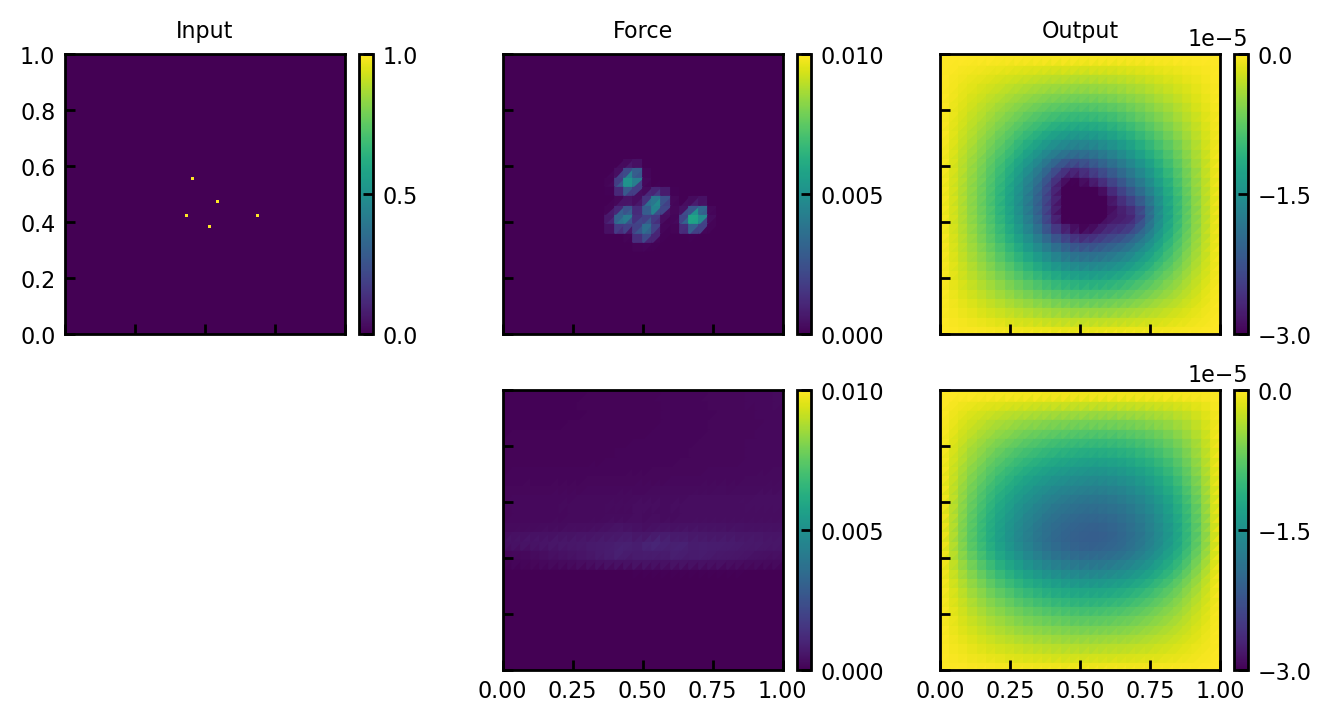

In [8]:
from train_pbnn import get_model, get_dataset
from mesh_utils import multichannel_img_to_mesh
from plot_utils import *
import yaml
from pprint import pprint

import torch

with open('../models/Poisson/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

model = get_model(config['model'])
train, val = get_dataset(config['dataset'])
model.eval()
model.to(device);

# Generate predictions
with torch.no_grad():
    sample = val[10]
    force = model(sample['inputs'].to(device))
    force = force.detach().cpu()

    force = multichannel_img_to_mesh(
        force,
        sample['grid_x'], sample['grid_y'],
        sample['function_space'],
        return_function=True,
    )
    pred = val.dataset.build_problem.forward(force)

    print(f'Loss with assigned force: {sample['Jhat'](force.vector()[:]):.3g}')

    force = force.compute_vertex_values()
    pred = pred.compute_vertex_values()

fig, ax = plt.subplots(2, 3, figsize=(8,4), sharex=True, sharey=True, squeeze=False)

plot_grid(ax[0, 0], sample['inputs'][2], sample['inputs'][0], sample['inputs'][1])
#plot_grid(sample['force'][0], sample['inputs'][:2], ax[0,1], vmin=0, vmax=0.01)
plot_mesh(ax[0, 2], sample['output'], val.dataset.mesh, vmin=-3e-5, vmax=0)

# Generate and plot model predictions
plot_mesh(ax[1, 1], force, val.dataset.mesh, vmin=0, vmax=0.01)
plot_mesh(ax[1, 2], pred, val.dataset.mesh, vmin=-3e-5, vmax=0)

f = multichannel_img_to_mesh(
    sample['force'], 
    sample['grid_x'], 
    sample['grid_y'], 
    sample['function_space'],
    return_function=True)
print(f'Loss with ground truth force: {sample['Jhat'](f.vector()[:]):.3g}')
plot_mesh(ax[0,1], f.compute_vertex_values(), val.dataset.mesh, vmin=0, vmax=0.01)

from scipy.ndimage import gaussian_filter
xyc = sample['inputs'].cpu().numpy()
f = gaussian_filter(xyc[2:], sigma=2) * np.sin(xyc[0:1]) * np.sin(xyc[1:2])
f = multichannel_img_to_mesh(
    f, 
    sample['grid_x'], 
    sample['grid_y'], 
    sample['function_space'],
    return_function=False)
f = f.T.flatten()
print(f'Loss with ground truth force: {sample['Jhat'](f):.3g}')


ax[0,0].set_title('Input')
ax[0,1].set_title('Force')
ax[0,2].set_title('Output')

ax[1,0].axis('off')

## Stokes problem

INFO:train_pbnn:Building a DolfinPBNN
INFO:train_pbnn:Loading model weights from ../models/Stokes/model_weight.ckpt
INFO:train_pbnn:Model reached loss=0.042 at epoch 1
INFO:train_pbnn:Loading dataset from ../data/stokes_dataset.hdf5
INFO:train_pbnn:Train dataset length: 820
INFO:train_pbnn:Val dataset length: 204


Loss with assigned force: 0.0301
Loss with ground truth force: 0.0605


(0.0, 1.0, 0.0, 1.0)

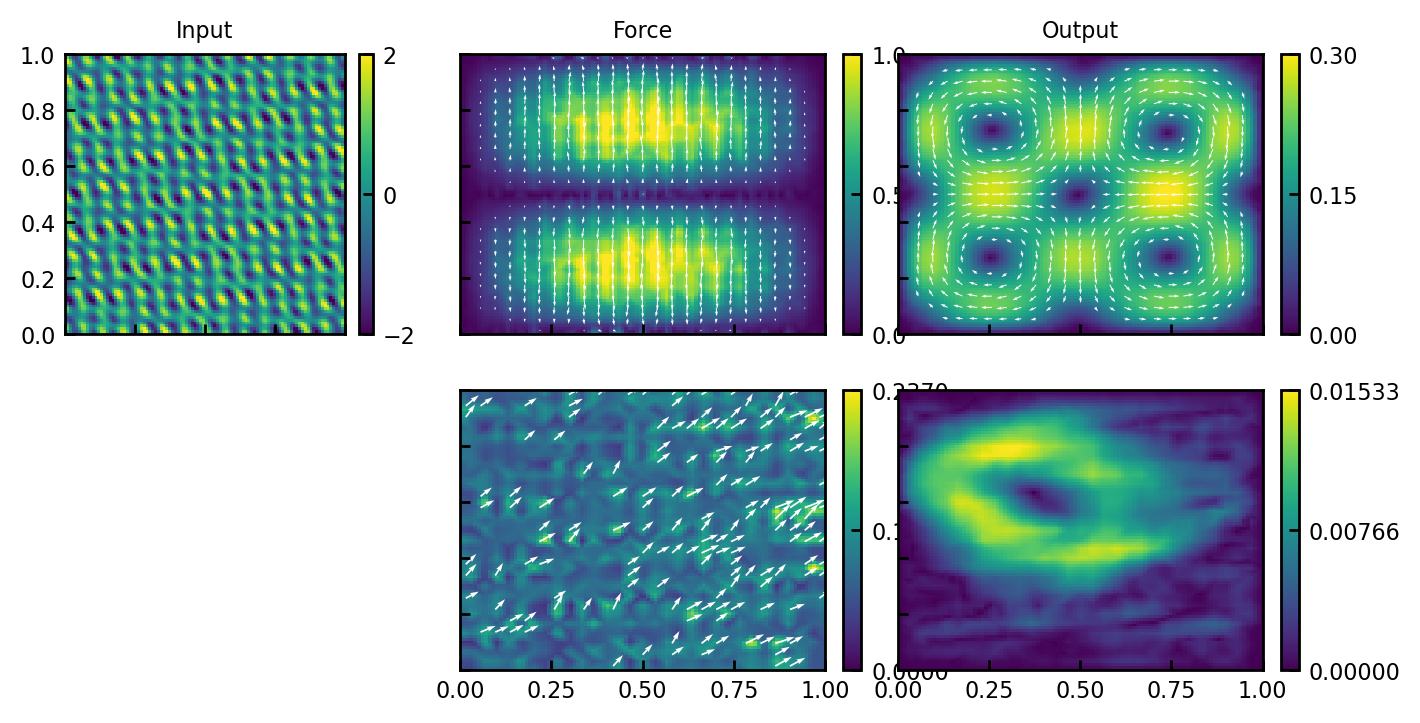

In [16]:
from train_pbnn import get_model, get_dataset
import yaml
from pprint import pprint

import torch

with open('../models/Stokes/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

model = get_model(config['model'])
train, val = get_dataset(config['dataset'])
model.eval()
model.to(device);

# Generate predictions
with torch.no_grad():
    sample = val[10]
    force = model(sample['inputs'].to(device))
    force = force.detach().cpu()

    force = multichannel_img_to_mesh(
        force,
        sample['grid_x'], sample['grid_y'],
        sample['function_space'],
        return_function=True,
    )
    pred = val.dataset.build_problem.forward(force)

    print(f'Loss with assigned force: {sample['Jhat'](force.vector()[:]):.3g}')

    force = force.compute_vertex_values().reshape([2, -1])
    pred = pred.compute_vertex_values().reshape([2, -1])

fig, ax = plt.subplots(2, 3, figsize=(8,4), sharex=True, sharey=True, squeeze=False)

inputs = sample['inputs'].cpu().numpy()
plot_grid(ax[0,0], inputs[2], inputs[0], inputs[1], vmin=-2, vmax=2)

F = sample['force']
#plot_grid_vector(ax[0,1], F, inputs[0], inputs[1], vmin=0, vmax=1)

outputs = sample['output']
plot_mesh_vector(ax[0,2], outputs, val.dataset.mesh, vmin=0, vmax=0.3)

# Generate and plot model predictions
plot_mesh_vector(ax[1,1], force, val.dataset.mesh, vmin=0)#, vmax=1)
plot_mesh_vector(ax[1,2], pred,  val.dataset.mesh, vmin=0)#, vmax=0.3)


f = multichannel_img_to_mesh(
    sample['force'], 
    sample['grid_x'], 
    sample['grid_y'], 
    sample['function_space'],
    return_function=True)
print(f'Loss with ground truth force: {sample['Jhat'](f.vector()[:]):.3g}')
f = f.compute_vertex_values().reshape([2, -1])
plot_mesh_vector(ax[0,1], f, val.dataset.mesh, vmin=0, vmax=1)

ax[0,0].set_title('Input')
ax[0,1].set_title('Force')
ax[0,2].set_title('Output')

ax[1,0].axis('off')

In [ ]:

plot_mesh(ax[0,1], f.compute_vertex_values(), val.dataset.mesh, vmin=0, vmax=0.01)